In [29]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from os.path import exists
import numpy as np
import time, math, sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.facecolor'] = 'white'

#sys.path.insert(0, '/home/joeadamo/Research/CovA-NN-Emulator')
from CovNet import Network_Full, Network_ReverseVGG, MatrixDataset

In [16]:
# IMPORTANT: Make sure the parameters here are the same as when you trained the network in question!
N = 52500
N_test = int(N*0.1)
train_log = True
train_inverse = False
training_dir = "/home/joeadamo/Research/Data/Training-Set/"
save_dir = "/home/joeadamo/Research/CovA-NN-Emulator/Plots/"

F_loss = nn.L1Loss()

In [5]:
# load the trained network
net = Network_Full(6, 100*100)
net.load_state_dict(torch.load('network-full.params'))

<All keys matched successfully>

In [13]:
# load the test set
t1 = time.time()
test_data = MatrixDataset(training_dir, int(N*0.1), int(N*0.9), train_log, train_inverse)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 26.68 s


In [22]:
t1 = time.time()
loss_data = np.zeros(N_test)
for (i, batch) in enumerate(test_loader):
    params = batch[0]; matrix = batch[1]
    prediction = net(params).view(100, 100)
    loss = F_loss(prediction, matrix)
    loss_data[i] = loss.item()

t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))
print("min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data), np.amax(loss_data), np.sum(loss_data) / N_test))

Done!, took 1 minutes 28.75 seconds
min loss: 0.074, max loss 1.104, avg loss: 0.461


In [63]:
# Let's do some more detailed analysis on a random matrix from the test set
idx = np.random.randint(0, N_test)
params = test_data[idx][0]
cov_actual = test_data[idx][1]
cov_predict = net(params).view(100,100)
print("loss = ", F_loss(cov_predict, cov_actual).item())
cov_predict = cov_predict.detach().numpy()
print("sample " + str(idx) + ", params:", params)

loss =  0.32820048928260803
sample 1514, params: tensor([ 6.9155e+01,  2.7389e-01,  1.4742e-01,  1.6215e-09,  2.0062e+00,
        -1.2820e+00])


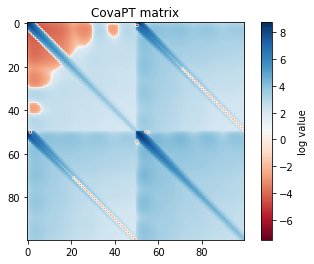

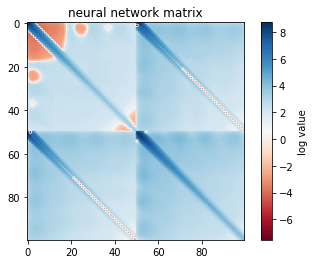

In [64]:
plt.figure()
plt.title("CovaPT matrix")
plt.imshow(cov_actual, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("neural network matrix")
plt.imshow(cov_predict, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

In [65]:
# Test for positive definite-ness
pos_diag = True
for i in range(cov_predict.shape[0]):
    if cov_predict[i,i] <= 0:
        pos_diag = False
print("diagonal is all positive:", pos_diag)

diagonal is all positive: True


0.00085288973


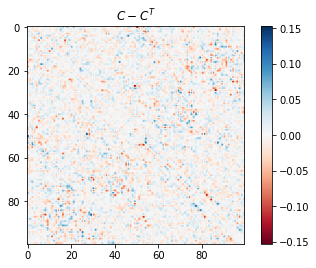

In [66]:
cov_sym = (cov_predict + cov_predict.T)
cov_asym = (cov_predict - cov_predict.T)
symmetric_val = np.linalg.norm(cov_asym, 2) / np.linalg.norm(cov_sym, 2)
print(symmetric_val)

plt.title(r"$C - C^T$")
plt.imshow(cov_asym, cmap="RdBu")
cbar = plt.colorbar()